### 1. Titre du projet
Modélisation des inondations et évaluations des vulnérabilités à **Kédougou et Mako (Bassin du fleuve Gambie): Juillet 2024**
Intégrations des données GHSL et outils PCRaster pour une gestion préventive des risques

### 2. Contexte et objectif
Ce projet vise à localiser les zones critiques en aval de la station de Kédougou en croisant le MNT, l'occupation du sol et les données GHSL

### 3. Données utilisées
- MNT du bassin versant du fleuve Gambie
- Landcover ESA WorldCover 
- Données GHSL (population et surface bâtie)
- Données de crue: https://mha.gouv.sn/la-situation-hydrologique-et-alerte-de-crue-sur-les-fleuves-senegal-et-gambie-du-11-octobre-2024/
- Coordonnées des stations Kédougou et Mako: HSM-SIEREM 2016

### 4. Technologies utilisées
- PCRaser: moteur principal de simulation pour la modélisation hydrologique, nottamment les fonctions accucapacityflux, accucapacitystate, spreadzone, ldd, etc.
- GDAL: convertion et manipulation de fichier raster (GeoTiff vers .map, reprojection, extraction de métadonnées).
- Numpy: manipulation efficace de matrice (ex. pour les conversions intermédiares ou calculs personnalisés).
- Matplotlib: visualisation des résultats(cartes des zones inondables, évolution temporelle).
- Jupyter notebook: environnement interactif pour tester, visualiser et documenter les simulations

### 5. Choix d'un modèle dynamique
Pour simuler le processus d'inondation sur le bassin Gambie, nous avons choisi d'utiliser un **modèle dynamique PCRaster** basé sur la classe `DynamicModel`.
#### Pourquoi un modèle dynamique?
- **Evolution temporelle** : Les phénomènes hydrologiques(écoulement, inondation, ruissellement) sont dépendants du temps. Le modèle dynamique permet d'intégrer cette évolution pas à pas.
- **Simulation réaliste** : Il permet d'observer l'impact cumulé des précipitation, de la topographie, de l'occupation du sol, etc sur la propagation de l'eau.
- **Flexibilité** : Grâce aux itérations temporelles, il est possible d'intégrer des paramètres variables dans le temps(ex. précipitations journalières, gestion des barrages, etc.).
Ce modèle est donc adapté pour reproduire et analyser le comportement spatial et  temporel des inondations dans le bassin.

### 6. Séparation des traitement statiques et dynamiques
Dans un souci de performation et de modularité, certains traitements geospataux lourds ou invariant ont été externalisés de la classe `DynamicModel`. L'objectif est de les exécuter une seule fois en amont, puis sauvegarder les résultats pour les réutilisés dans la simulation dynamiques

### 7. Traitements préalables effectués hors de `DynamicModel`

#### a. Importation des bibliothèques python

In [12]:
import pcraster as pcr
import numpy as np
import glob
import os
%matplotlib inline
import matplotlib.pyplot as plt
from osgeo import gdal, osr, gdalconst
from tqdm import tqdm # pour une barre de progression
from pyproj import Transformer
from pcraster.framework import DynamicModel
#from riverrem.REMMaker import REMMaker
import math
gdal.UseExceptions()

In [24]:
#rem_maker = REMMaker(dem='Data/basincover.tif', out_dir='./Data')
#rem_maker.make_rem()
#rem_maker.make_rem_viz(cmap='topo')

In [25]:
#dem = gdal.Open('Data/basin_dem.tif') # le Modèle Numérique Terrestre
#landcover = gdal.Open('Data/basincover.tif') # les données sur l'occupation du sol
#ghsl_built = gdal.Open('Data/basin_built.tif') # les données GHSL de la distribution des surfaces urbanisées (bâties), exprimées en mètres carrés 2020
#ghsl_pop = gdal.Open('Data/basin_pop.tif') # les données GHSL de la distribution spatiale de la population en 2020

#### b. Imporation des données et affichage des proprietés de nos dataset

In [26]:
# Fonction pour l'affichage des proprietés des datasets
def gdal_properties(input_path): # Affichier les proprietés pour chaque fichier
    if not os.path.exists(input_path):
        raise ValueError(f"Fichier introuvable")
    raster = gdal.Open(input_path)
    path = raster.GetDescription()
    width = raster.RasterXSize
    height = raster.RasterYSize
    projection = raster.GetProjection()
    geotransform = raster.GetGeoTransform()
    metadata = raster.GetMetadata()
    numband = raster.RasterCount # chacune de nos rasters ne renferme qu'une bande
    
    band = raster.GetRasterBand(1)
    data_type = band.DataType
    data_type_name = gdal.GetDataTypeName(data_type)
    print(f"Le type de données de la bande 1: {data_type_name}")
    driver = raster.GetDriver().ShortName
    print("#############################################")
    print('Propriétés')
    print(f"{path} a {width} x {height} comme dimension")
    print(f"Driver: {driver}")
    print(f"Nombre de bande: {numband}")
    print(f"Les metadonnées: {metadata}")

    srs = osr.SpatialReference() 
    srs.ImportFromWkt(projection)
    epsg_code = srs.GetAuthorityCode(None)
    unit_name = "Degree" if epsg_code == "4326" else srs.GetLinearUnitsName()
    unit_value = srs.GetLinearUnits()
    print(f"Unité de la projection: {unit_name} {unit_value}")

    if geotransform:
        
        print(f"Origine: ({geotransform[0]}, {geotransform[3]})")
        print(f"Size: ({geotransform[1]} {unit_name}, {geotransform[5]} {unit_name})")
    layerBand = raster.GetRasterBand(1)
    min_value, max_value = layerBand.ComputeRasterMinMax()
    print(f"Valeur minimale {min_value}")
    print(f"Valeur maximale {max_value}")
    print("#############################################")
    raster = None

In [27]:
basin_raster_paths = glob.glob('Data/basin*.tif') # Charger les fichiers geotiff
for path in basin_raster_paths:
    
    gdal_properties(path)
    print('\n')

Le type de données de la bande 1: UInt16
#############################################
Propriétés
Data/basin_built.tif a 20060 x 17852 comme dimension
Driver: GTiff
Nombre de bande: 1
Les metadonnées: {'AREA_OR_POINT': 'Area'}
Unité de la projection: m 1.0
Origine: (-1721000.0, 2052780.0)
Size: (30.0 m, -30.0 m)
Valeur minimale 0.0
Valeur maximale 6599.0
#############################################


Le type de données de la bande 1: Int16
#############################################
Propriétés
Data/basin_dem.tif a 18137 x 12359 comme dimension
Driver: GTiff
Nombre de bande: 1
Les metadonnées: {'AREA_OR_POINT': 'Area'}
Unité de la projection: Degree 1.0
Origine: (-16.15022041715082, 14.68830289986267)
Size: (0.0002694945852358564 Degree, -0.0002694945852358564 Degree)
Valeur minimale -29.0
Valeur maximale 1530.0
#############################################


Le type de données de la bande 1: Float64
#############################################
Propriétés
Data/basin_pop.tif a 15897 

#### c. Alignement des rasters
Pour une cohérence spatiales, une interopérabilité entre les données et une optimisation des calculs, on va aligner nos rasters sur une même grille, avec:
- une projection commune(EPSG:32628 - UTM Zone 28N)
- Une résolution fixe (100m). Le choix de cette résolution repose sur un compromis entre la capacité de traitement disponible et une précision géographique. Une résolution fine (30m, 10m) offrirait plus de détails mais générerait des rasters de grande taille difficillement manipulables dans une environnement contraint comme mon ordinateur personnel avec une RAM(2Go) un processeur(Intel celeron CPU N3050) limité.
- Une origine spatiale commune bassée sur le MNT Projeté

Etape 1: Reprojection du MNT

In [28]:
def reproject_raster_get_origin(input_raster, target_epsg=32628, resolution=30):
    output_raster = "Data/mnt_utm.tif"
    warp_options = gdal.WarpOptions(
        dstSRS=f"EPSG:{target_epsg}",
        xRes=resolution,
        yRes=resolution,
        resampleAlg='near'
    )
    gdal.Warp(output_raster, input_raster, options=warp_options)

    ds = gdal.Open(output_raster)
    gt = ds.GetGeoTransform()
    origin_x = gt[0]
    origin_y = gt[3]
    width = ds.RasterXSize
    height = ds.RasterYSize
    ds = None
    return origin_x, origin_y, width, height, output_raster


Etape 2: Alignement des autres rasters

In [29]:
def align_raster(input_raster, output_raster, reference_epsg, resolution, origin_x, origin_y, width, height, resampleAlg):
    warp_options = gdal.WarpOptions(
        dstSRS=f"EPSG:{reference_epsg}",
        xRes=resolution,
        yRes=resolution,
        outputBounds=(
            origin_x,
            origin_y - resolution * height,
            origin_x + resolution * width,
            origin_y
        ),
        width=width,
        height=height,
        resampleAlg=resampleAlg
    )
    gdal.Warp(output_raster, input_raster, options=warp_options)
    
    print(f"Raster reprojeté et aligné sauvegardé : {output_raster}")
    print('\n')


Etape 3: Utilisation

In [30]:
# Reprojection du MNT et extraction des métadonnées
mnt_path = 'Data/basin_dem.tif'
origin_x, origin_y, width, height, mnt_reprojected = reproject_raster_get_origin(mnt_path)

# Alignment des autre rasters
input_data = {
    'mnt': {
        'input_path': 'Data/basin_dem.tif',
        'output_path': 'Data/Aligned_rasters/mnt_aligned.tif',  # Donnée continue (altitude)
        'resampleAlg': 'bilinear'
    },
    'landcover': {
        'input_path': 'Data/basincover.tif',
        'output_path': 'Data/Aligned_rasters/landcover_aligned.tif',  # Donnée discret (occupation du sol)
        'resampleAlg': 'near'
    },
    'ghsl_built': {
        'input_path': 'Data/basin_built.tif',
        'output_path': 'Data/Aligned_rasters/ghsl_built_aligned.tif',  # Donnée continue (surface bâtie)
        'resampleAlg': 'bilinear'
    },
    'ghsl_pop': {
        'input_path': 'Data/basin_pop.tif',
        'output_path': 'Data/Aligned_rasters/ghsl_pop_aligned.tif',  # Donnée continue (population)
        'resampleAlg': 'bilinear'
    }
}
for name, infos in tqdm(input_data.items()): # tqdm permet d'aficher la progression
    align_raster(
        input_raster=infos['input_path'],
        output_raster=infos['output_path'],
        reference_epsg=32628,
        resolution=100,
        origin_x=origin_x,
        origin_y=origin_y,
        width=width,
        height=height,
        resampleAlg=infos['resampleAlg']
    )


 25%|███████████▎                                 | 1/4 [00:13<00:40, 13.54s/it]

Raster reprojeté et aligné sauvegardé : Data/Aligned_rasters/mnt_aligned.tif




 50%|██████████████████████▌                      | 2/4 [00:17<00:15,  7.88s/it]

Raster reprojeté et aligné sauvegardé : Data/Aligned_rasters/landcover_aligned.tif




 75%|█████████████████████████████████▊           | 3/4 [00:25<00:08,  8.14s/it]

Raster reprojeté et aligné sauvegardé : Data/Aligned_rasters/ghsl_built_aligned.tif




100%|█████████████████████████████████████████████| 4/4 [01:34<00:00, 31.87s/it]

Raster reprojeté et aligné sauvegardé : Data/Aligned_rasters/ghsl_pop_aligned.tif




100%|█████████████████████████████████████████████| 4/4 [01:34<00:00, 23.60s/it]


#### d. Verification de l'alignement des rasters

In [31]:
aligned_raster_paths = glob.glob('Data/Aligned_rasters/*.tif')
for path in aligned_raster_paths:
    
    gdal_properties(path)
    print('\n')

Le type de données de la bande 1: UInt16
#############################################
Propriétés
Data/Aligned_rasters/ghsl_built_aligned.tif a 17786 x 12389 comme dimension
Driver: GTiff
Nombre de bande: 1
Les metadonnées: {'AREA_OR_POINT': 'Area'}
Unité de la projection: metre 1.0
Origine: (374491.5725851272, 1627184.8412821454)
Size: (100.0 metre, -100.0 metre)
Valeur minimale 0.0
Valeur maximale 6022.0
#############################################


Le type de données de la bande 1: Int16
#############################################
Propriétés
Data/Aligned_rasters/mnt_aligned.tif a 17786 x 12389 comme dimension
Driver: GTiff
Nombre de bande: 1
Les metadonnées: {'AREA_OR_POINT': 'Area'}
Unité de la projection: metre 1.0
Origine: (374491.5725851272, 1627184.8412821454)
Size: (100.0 metre, -100.0 metre)
Valeur minimale -10.0
Valeur maximale 1524.0
#############################################


Le type de données de la bande 1: Byte
#############################################
Propr

#### f. Traduction les fichiers GeoTiff déja alignés en fichier pcraster(.map)
PCRaster n'accepte que ses propres fichiers .map en entrée pour ses fonctions(lddcreate, streamorder, accuflux, etc.).
Même si un GeoTIFF contient la même information, `PCRaster` ne peut pas lire directement un .tif.
Donc il faut convertir en .map pour lire directement un .tif

In [32]:
# Définition de la fonction de conversion
def convert_to_pcraster(input_filename, output_filename, gdal_type,value_scale):

    #gdal.SetConfigOption("PCRASTER_VALUESCLAE", value_scale)
    gdal.UseExceptions()
    src_ds = gdal.Open(input_filename, gdalconst.GA_ReadOnly)
    
    gdal.Translate(output_filename, src_ds, format="PCRaster", outputType=gdal_type, metadataOptions=value_scale)#creationOptions=[f"VALUESCALE={value_scale}"])
    print(f"Converti : {input_filename} en {output_filename}")
    
    #GDAL Translate
    #dst_ds = gdal.Translate(dst_filename, src_ds, format='PCRaster', outputType=ot, metadataOptions=VS)
    
    # Libérer proprement les objets en mémoire
    dst_ds = None
    src_ds = None
    


In [33]:
# Exécution de de la fonction de conversion des fichiers .tif en .map
input_filenames = {
    'Data/Aligned_rasters/mnt_aligned.tif': {
        'output': 'Data/PCRaster_files/mnt.map',
        'value_scale': 'VS_SCALAR',
        'gdal_type': gdalconst.GDT_Float32
    },
    'Data/Aligned_rasters/landcover_aligned.tif': {
        'output': 'Data/PCRaster_files/landcover.map',
        'value_scale': 'VS_NOMINAL',
        'gdal_type': gdalconst.GDT_Byte
    },
'Data/Aligned_rasters/ghsl_built_aligned.tif': {
        'output': 'Data/PCRaster_files/ghsl_built.map',
        'value_scale': 'VS_SCALAR',
        'gdal_type': gdalconst.GDT_Float32
    },
'Data/Aligned_rasters/ghsl_pop_aligned.tif': {
        'output': 'Data/PCRaster_files/ghsl_pop.map',
        'value_scale': 'VS_SCALAR',
        'gdal_type': gdalconst.GDT_Float32
    }
}
# Lancer les conversations
for filename, infos in input_filenames.items():
    convert_to_pcraster(input_filename=filename,
                       output_filename=infos['output'],
                       value_scale=infos['value_scale'],
                       gdal_type=infos['gdal_type'])


Converti : Data/Aligned_rasters/mnt_aligned.tif en Data/PCRaster_files/mnt.map
Converti : Data/Aligned_rasters/landcover_aligned.tif en Data/PCRaster_files/landcover.map
Converti : Data/Aligned_rasters/ghsl_built_aligned.tif en Data/PCRaster_files/ghsl_built.map
Converti : Data/Aligned_rasters/ghsl_pop_aligned.tif en Data/PCRaster_files/ghsl_pop.map


- Carte du Modèle Numérique Terrestre

In [14]:
""" L'exception single resize rencontré lors de l'utilisation de pcr2numpy provient d'une incompatibilité entre la taille
du rastercourant en mémoire dans pcraster et celle du du raster que l'on souhaite convertir. Par conséquent PCRaster
interdit interdit le redimenssionnement automatique pour éviter des incohérence dans les calculs.
Afin de contourner cette contrainte, une fonction personnalisée a été mise en place """
# Fonction personnalisée à la place de pcr2numpy
def pcr_to_numpy(pcr_map, nodata_value):
    rows = pcr.clone().nrRows()
    cols = pcr.clone().nrCols()
    pcr_array = np.zeros((rows, cols), dtype=np.float32)
    for row in range(0, rows):
        for col in range(0, cols):
            value, mv =  pcr.cellvalue(pcr_map, row + 1, col + 1)
            if mv is False:
                value = nodata_value
            pcr_array[row, col] = value
    #pcr_array = pcr_array.astype(int)
    return pcr_array

In [15]:
# Fonction pour la visualisation du MNT(format PCRaster)
def visualization_mnt(mnt_numpy):
    plt.figure(figsize=(12, 12))
    plt.imshow(mnt_numpy, cmap='terrain', alpha=0.5, origin='upper')
    plt.colorbar()
    plt.title('Modèle Numérique Terrain du bassin du fleuve Gambie')
    plt.show()
    plt.close()

In [16]:
# charger le MNT
#mnt = pcr.readmap('Data/PCRaster_files/mnt.map')
# Convertir mnt en tableau numpy
#mnt_numpy = pcr_to_numpy(mnt)
# Visualisation
#visualization_mnt(mnt_numpy)

MemoryError: std::bad_alloc

#### g. Génération de LDD (Local Drain Direction)
Le LDD est une composante fondamentale dans toute modélisation hydrologique. Il représente, pour chaque cellule du MNT, la direction dans laquelle l'eau s'écoule vers une cellule voisine. Cette structure est indispensable pour simuler le ruissellement, l'accumulation ou les inondations. Avant de générer la direction de l'écoulement, nous allons corrigé les dépressions sur le Modèle Numérique Terrain.

In [37]:
# Une carte de clone
#pcr.setclone('Data/PCRaster_files/mnt.map')

In [17]:
# Fonction de calcul de direction
def calculate_flow_direction(dem_file):
    dem = pcr.readmap(dem_file)
    #dem_filled = pcr.lddcreatedem(dem, 1e31, 1e31, 1e31, 1e31)
    #pcr.report(dem_filled, 'Data/PCRaster_files/mnt_corrige.map')
    
    flow_direction = pcr.lddcreate(dem, 1e31, 1e31, 1e31, 1e31)
    pcr.report(flow_direction, 'Data/PCRaster_files/ldd.map')
    #return ldd

#calculate_flow_direction('Data/PCRaster_files/mnt.map')

#### h. Délimition du fleuve Gambie dans le cadre de la modélisation des inondations:
Dans le cadre de ce projet, l'objectif principal de la délimitation du cours est d'identifier précisément le lit majeur du fleuve Gambie, en excluant les affluents secondaires. Cette délimitation est essentielle pour:
- Localiser les zones suceptibles d'être inondées à proximité immédiate du fleuve
- Simuler l'expension spatiale des inondations depuis le fleuve principal.
- Intégrer les stations de mesure (Kédougou et Mako) dans une analyse cohérente et réaliste

##### Méthode utlisée: ordre de strahler: 
Pour identifier le fleuve principale parmi l'ensemble des réseaux hydrographique, nous allons utilisé la technique basée sur **l'ordre de Strahler** qui permet de:
+ classer les rivières selon leur importance topologique dans un réseau hydrographique
+ Filtrer les affuents secondaires à l'aide d'un seuil élevé
+ Générer une carte du cours d'eau principal à partir d'un LDD (local Drainage Direction)

In [18]:
# Calculer l'ordre de Strahler et extraire le réseau pour chaque ordre
def stream_delineation(flow_direction_map): # Avec comme paramètre, le LDD
    
    orders = pcr.streamorder(flow_direction_map)
    pcr.report(orders, 'Data/Streams/strahler.map') # enregistrer sous forme de carte pcraster les ordres de Strahler
    """order_max = pcr.mapmaximum(orders)
    order_max_value = pcr.cellvalue(order_max, 1, 1)[0]
    for order in range(1, order_max_value+1):
        stream = pcr.ifthen(orders >= order, pcr.scalar(1))
        pcr.report(stream, f'Data/Streams/stream{str(order)}.map')"""
    return orders


In [19]:
# Charger le réseau de drainage générer à partir de la fonction calculate_flow_direction
ldd = pcr.readmap('Data/PCRaster_files/ldd.map')

##### validation 
1. Objectif
L'objectif est de valider si le réseau hydrographique extrait à partir des ordres de Stahler assure une connexion continue entre ls stations de Kédougou et Mako.
2. Méthode
* Filtrage de cours d'eau
Sélectionner uniquement les rivières ayant un ordre de Stahler supèrieur ou égal à un seuil donnée
* Affichage Graphique
Afficher en fond de carte les cours d'eau sélectionner puis placer les stations Kédougou et Mako sur la carte.
* Observation
Vérifier visuellement si les stations Kédougou et Mako tombent dans le masque.
3. Justification de la méthode
* La validation graphique permet d'observer directement la structure du résau hydrographique sans ambiguité
* Elle offre une onfirmation visuelle de la connectivité entre les deux stations, ce qui est plus fiable qu'une validation numérique

In [20]:

#définition d'une fonction de conversion des coordonnées géographiques en indice de pixel ou inversement
def geoToPixel(lon, lat, geotransform, inverse=False):
    """
    les coordonées GPS(longitude, latitude) des stations Hydrometrique doivent être convertis en coordonnées image(ligne, colonne).
    La conversion est nécessaire lorsqu'on travaille avec des rasters(comme un MNT, un LDD).
    - Station Kégoudou (-12.1833, 12.55)
    - Station Mako (-12.35, 12.8667)
    D'abord on va convertir les coordonnées géographiques en coordonnées projetées"""
    # 
    def gps_to_utm(lon, lat): #fonction pour convertir les coordonnées géographiques en coordonnées projetées
        transformer_wgs = Transformer.from_crs("EPSG:4326", "EPSG:32628", always_xy=True)
        
        x_proj, y_proj = transformer_wgs.transform(lon, lat)
        return [x_proj, y_proj]
        
    
    
    if inverse is True: 
        """si inverse est True, x et y sont en coordonnées géographiques, donc on les converties en coordonnées pixel
        après reprojection"""
        #print("Convertir Pixel à Géo")
        xcoord = geotransform[0] + x * geotransform[1]
        ycoord = geotransform[3] + y * geotransform[5]
    
    
    elif inverse is False:
            
        """si inverse est False, x et y sont en coordonnées pixel, donc on les converties en coordonnées projetées
        après reprojection"""
        x_utm, y_utm = gps_to_utm(lon, lat)
        #print("Convertir Géo a Pixel")
        xcoord = int((x_utm - geotransform[0]) / geotransform[1])
        ycoord = int((y_utm - geotransform[3]) / geotransform[5])
    else:
        print("le raster n'a pas de trasnformation")
    return xcoord, ycoord
#tester la fonction sur notre raster
# Choisir un GeoTransformation à partir de nos raster

#print(f"Station Kédougou en Coordonées image {kedougou}")
#print(f"Station Mako en Coordonées image {mako}")

1

In [21]:
def visualization_ldd_and_strahlers(ldd_numpy, strahler_calibrated_numpy, strahlers_complete_numpy,
                                    kedoudou_pixel_x, kedougou_pixel_y, mako_pixel_x, mako_pixel_y, threshold):
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. Carte LDD
    axes[0, 0].imshow(ldd_numpy, cmap='viridis')
    axes[0, 0].set_title('Local Drain Direction(LDD)', fontsize=14)
    
    # 2. Carte Strahler avec ordre >= threshold en surbrillance
    axes[0, 1].imshow(strahler_calibrated_numpy, cmap='viridis')
    axes[0, 1].scatter(kedoudou_pixel_x, kedougou_pixel_y, color='blue', label='Kedougou', marker='x')
    axes[0, 1].scatter(mako_pixel_x, mako_pixel_y, color='red', label='Mako', marker='*')
    axes[0, 1].legend()
    axes[0, 1].set_title(f'Strahler >= {threshold}', fontsize=14)
    
    
    
    # 3. Carte de tous les ordres de Strahler
    axes[1, 0].imshow(strahlers_complete_numpy, cmap='viridis')
   
    axes[1, 0].set_title('Tous les ordres de Strahler', fontsize=14)
    
    
    # 4. Histogramme des ordres
    strahler_flat = strahlers_complete_numpy.flatten()
    axes[1, 1].hist(strahler_flat, bins=np.arange(1, np.max(strahlers_complete_numpy)+2)-0.5, edgecolor='black')
    axes[1, 1].set_yscale('log')
    axes[1, 1].set_title('Distribution des ordres de Strahler', fontsize=14)
    axes[1, 1].set_xlabel('Ordre')
    axes[1, 1].set_ylabel('Fréquence')
    axes[1, 1].grid(True)
    
    # Mise en forme
    plt.tight_layout()
    plt.show()
    plt.close()

In [22]:
# paramètres
ldd_numpy = pcr_to_numpy(ldd, np.nan) # convertir le LDD en tableau numpy
orders = stream_delineation(ldd) # Ordre de strahler, ordre maximum 11
orders_numpy = pcr_to_numpy(orders, np.nan)


In [23]:
strahler_order_threshold = 10 # doit être calibré, ne peut pas être fait automatiquement
strahler_threshold_order = orders >= strahler_order_threshold # Capturer les cours d'eau avec un ordre >= 8
pcr.report(strahler_threshold_order, './Data/Streams/river.map')
strahler_threshold_order_numpy = pcr_to_numpy(strahler_threshold_order, np.nan)
geotransform = gdal.Open('Data/Aligned_rasters/mnt_aligned.tif').GetGeoTransform()
kedoudou_pixel_x, kedougou_pixel_y = geoToPixel(-12.1833, 12.55, geotransform) # coordonnées en pixel de la station Kédougou
mako_pixel_x, mako_pixel_y= geoToPixel(-12.35, 12.8667, geotransform) # coordonnées en pixel de la station de Mako


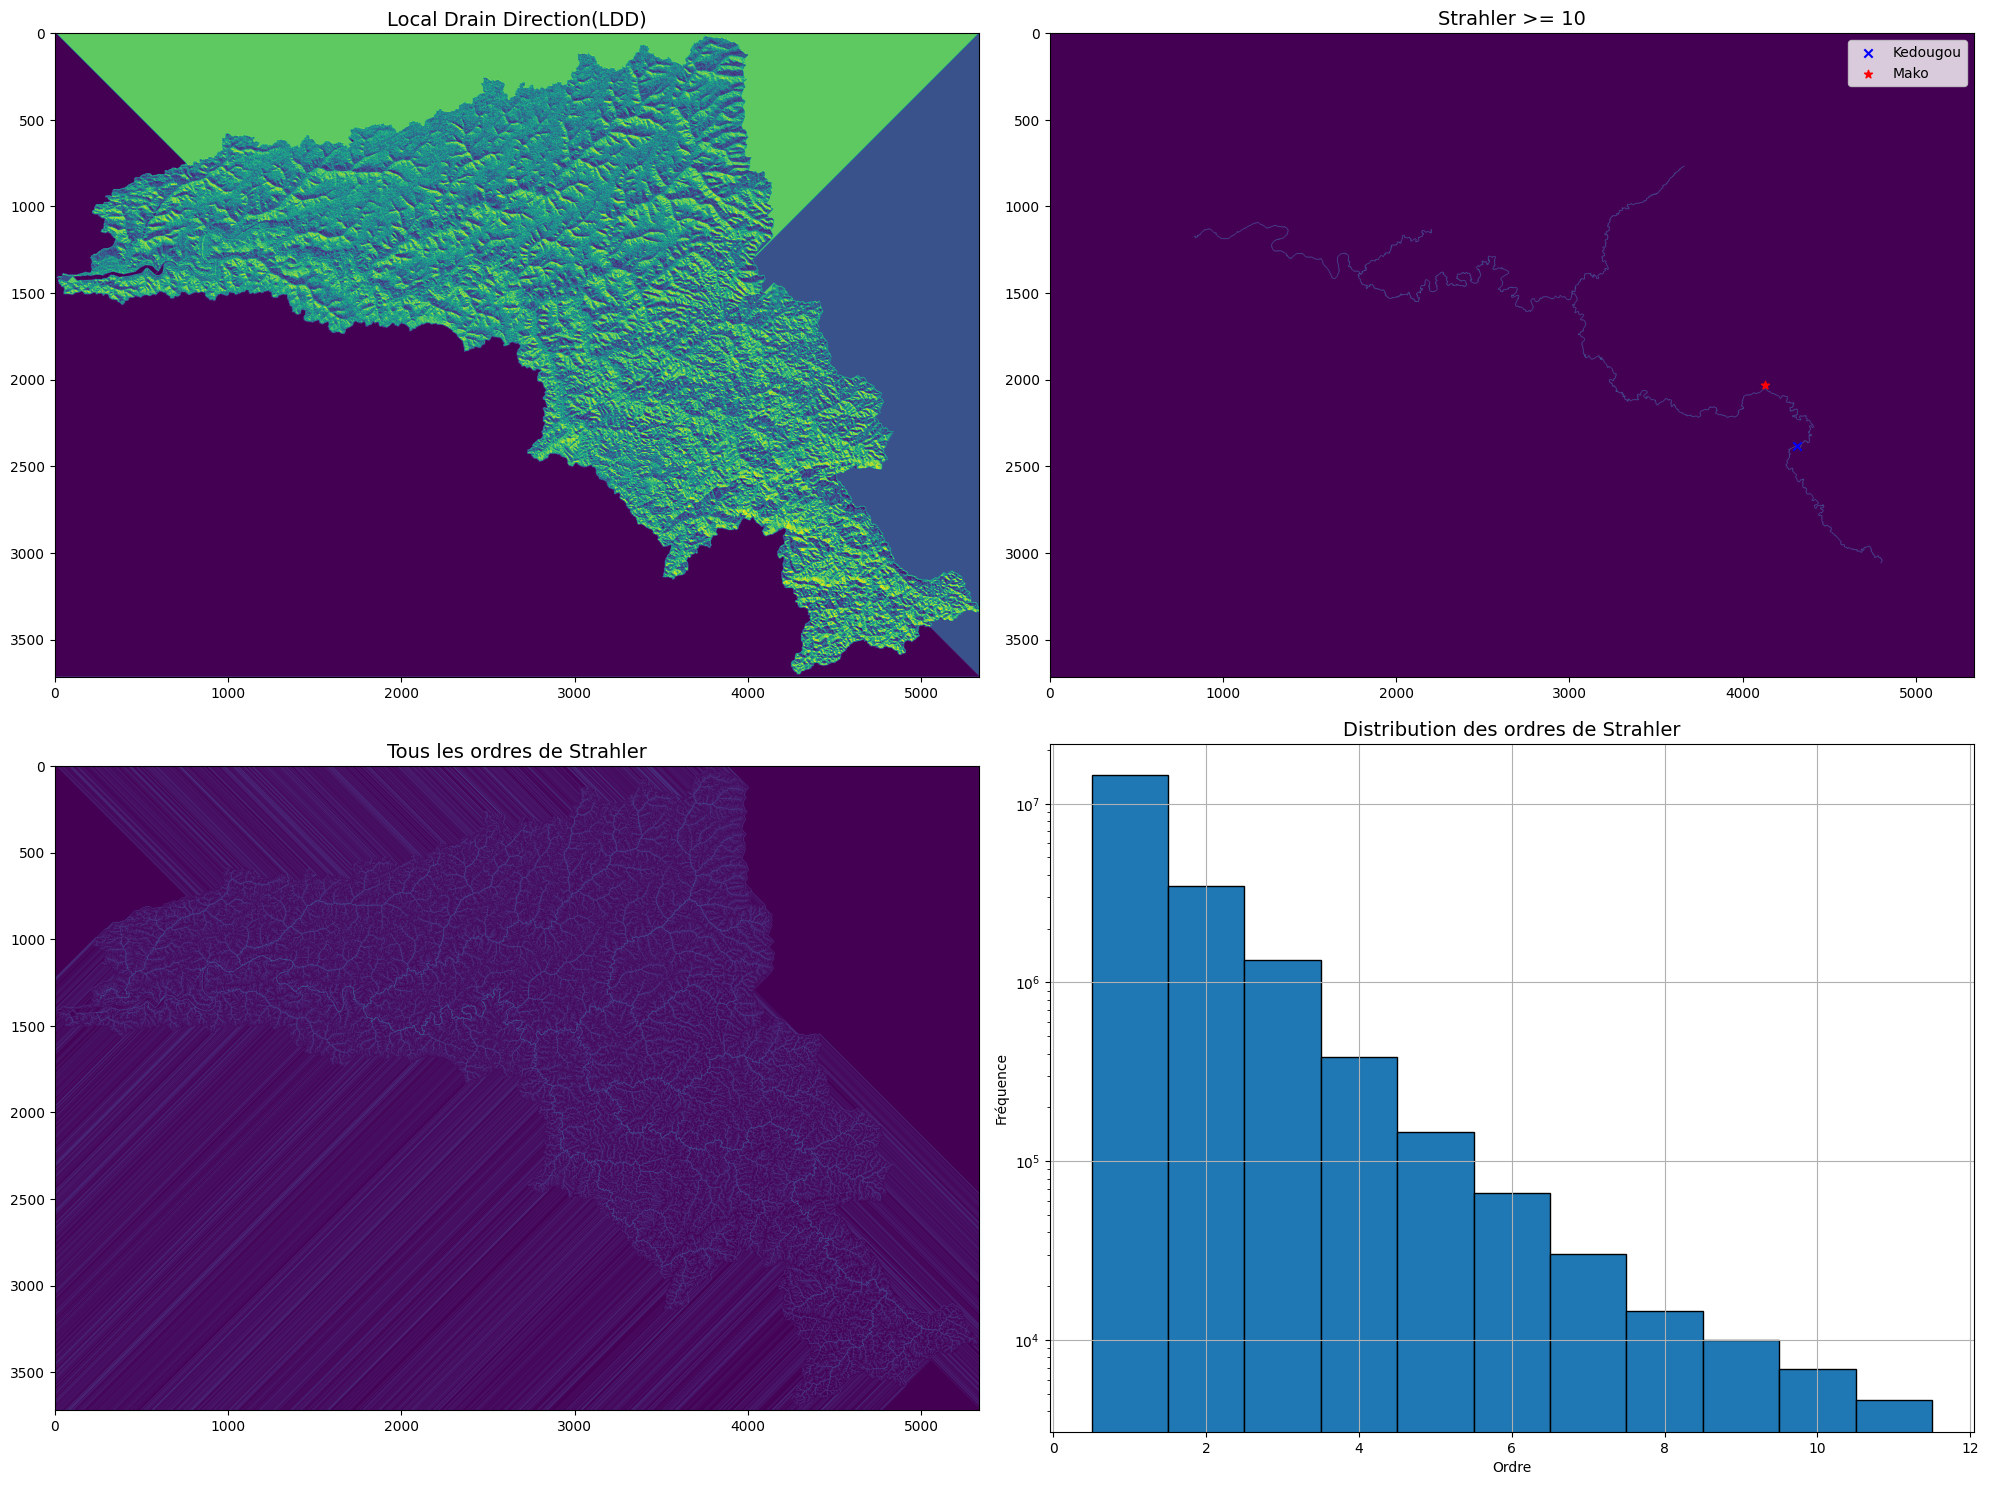

In [13]:
# Visualisation
visualization_ldd_and_strahlers(ldd_numpy=ldd_numpy, 
                                strahler_calibrated_numpy=strahler_threshold_order_numpy, 
                                strahlers_complete_numpy=orders_numpy, 
                                kedoudou_pixel_x=kedoudou_pixel_x, 
                                kedougou_pixel_y=kedougou_pixel_y,
                                mako_pixel_x=mako_pixel_x, 
                                mako_pixel_y=mako_pixel_y,
                                threshold=strahler_order_threshold)

##### Commentaire
En utilisant l'approche graphique, les stations de Kédougou et de Mako ont été capturée par les segments d'ordre 10, l'ordre maximal étant 11. Cela indique que l'ordre 10 correspond au tronçon principal du fleuve Gambie entre les deux stations, tandis que l'ordre 11 est atteint plus en aval. Cet approche permet d'inclure non seulement les segments d'ordre 10, correspondant aux stations de Kédougou et Mako, mais également les portions de cours atteignant l'ordre maximal(11).

In [15]:
pcr.cellvalue(orders, kedougou[1], kedougou[0])[0]

(1, True)

(array([0., 1.]), array([19821135,    12777]))

In [8]:
ordre_11 = strahlers == 8
array = pcrasterNumpy(ordre_11)

#### i. Définition de points de mesure au niveau des stations (Kédougou et Mako)
Chaque carte va définir où est la station

In [25]:
def station_mask(x_station, y_station, template_map_path, output_path):
    """
    Créer une carte pcraster avec la station positionnée au bon endroit.
    Paramètre :
    - x_station: coordonnées x, en pixel, de la station
    - y_station: coordonnées y, en pixel, de la station
    - template_map_path: chemin vers un raster modèle
    """

    # 1. Lire les proprietés du modèle
    pcr.setclone(template_map_path)
    
    # 2. Charger les infos de géoréférencement
    clone = pcr.clone()
    nrow = clone.nrRows()
    ncol = pcr.clone().nrCols()
    
    # 3. Créer une matrice vide
    station_array = np.zeros((nrow, ncol), dtype=np.int8)
    
    if 0 <= x_station < ncol and 0 <= y_station < nrow:
        
        station_array[y_station, x_station] = 1
    else:
        raise ValueError('Station hors des limites du raster')
    # 4. Transformer en raster PCRaster
    station_raster = pcr.numpy2pcr(pcr.Boolean, station_array, 0)
    pcr.report(station_raster, output_path)
    print(f'Carte station créée: {output_path}')
    

In [26]:
template_map_path = './Data/PCRaster_files/landcover.map'
stations = {
    'kedougou':{
        'x': kedoudou_pixel_x,
        'y': kedougou_pixel_y,
        'output_path': './Data/Stations/kedoudou.map'
    },
    'mako':{
        'x': mako_pixel_x,
        'y': mako_pixel_y,
        'output_path': './Data/Stations/mako.map'
    }
}
for name, infos in stations.items():
     station_mask(
         x_station=infos['x'], 
         y_station=infos['y'], 
         template_map_path=template_map_path, 
         output_path=infos['output_path'])

Carte station créée: ./Data/Stations/kedoudou.map
Carte station créée: ./Data/Stations/mako.map


### 8. Mise en place du `DynamicModel`
Après l'identification du cours d'eau principal à partir de l'ordre de Strahler (&#8805; 10). La prochaine étape consiste à simuler de manière temporelle le comportement hydrologique du bassin versant à l'aide du **modèle dynamique**. Ce type de modèle permet d'intégrer l'évolution des processus hydrologiques dans le temps, tels que l'écoulement, le ruissellement ou les inondations.

#### a. Préparation du modèle

In [53]:
class FloodModel(DynamicModel):
    def __init__(self):
        DynamicModel.__init__(self)
        pcr.setclone('./Data/PCRaster_files/mnt.map')
        
    def initial(self):
        
        # Chargement des données
        self.dem = pcr.readmap('./Data/PCRaster_files/mnt.map')               # Modèle Numérique Terrain
        self.landcover = pcr.readmap('./Data/PCRaster_files/landcover.map')   # Occupation du sol
        self.station_kedougou = pcr.readmap('./Data/Stations/kedoudou.map')   # Station Kédougou
        self.station_mako = pcr.readmap('./Data/Stations/mako.map')           # Station Mako
        self.ldd = pcr.readmap('./Data/PCRaster_files/ldd.map')               # Réseau de drainage du fleuve
        self.river = pcr.readmap('./Data/Streams/river.map')       # Lit pricipal du fleuve
        
        # Paramètres Hydrologiques
        self.debit_base = 50   # m3/s (débit permenant)
        self.debit_crue = 173  # m3/s (débit constant)
        self.n_manning = 0.035 # Coefficient de rugosité
        
        """runoff_coeff = {'couverture arborée': 0.1, 'arbustes': 0.2 , 'prairie': 0.3, 'terre cultivée': 0.3,
        'construit': 0.7, 'végétation nue/eparse': 0.4, 'neige et glace': 0.6, 'plans d'eau permenant': 1,
        'zone humide et herbacée': 0.1, 'mangroves': 0.1, 'mousse et lichen': 0.05}"""
        self.runoff_coeff = pcr.lookupscalar('./Data/runoff_coeff.tbl', self.landcover)
        
        # Capacité du lit (uniquement sur fleuve)
        slope = pcr.slope(self.dem)
        """
        surface mouillée: A = largeur * profondeur,     80*20=1600m2
        périmètre mouillé P = largeur + 1 * profondeur, 80+2*20=120m
        rayon hydraulique R = A/P, 1600/120=13.33
        coefficient manning n = 0.035
        pente S = slope
        capacité Q = (A * (R**(2/3)) * math.sqrt(S))
        """
        self.channel_cap = pcr.ifthenelse(self.river, 
                                          (1600 * (13.33**(2/3)) * math.sqrt(slope)) / self.n_manning,
                                          pcr.scalar(0) # Aucune capacité hors du lit
                                         )
        
        
        
        # Initialisation des variables d'état
        self.channel_storage = pcr.ifthenelse(self.river, 
                                              pcr.scalar(self.debit_base), # Débit de base
                                              pcr.scalar(0))
        self.overland_flow = pcr.scalar(0)
        self.time_step = 0
        
    def dynamic(self):
        self.time_step += 1
        # Débit constantat à Kedougou (base + crue)
        debit_total = self.debit_base + self.debit_crue
        
        # Injection du débit uniquement à Kédougou
        channel_inflow = pcr.ifthenelse(self.station_kedougou, pcr.scalar(debit_total), pcr.scalar(0))
        
        # Ecoulement dans le lit principal
        channel_flux = pcr.accucapacityflux(self.ldd, channel_inflow + self.channel_storage, self.channel_cap)
        self.channel_storage = pcr.accucapacitystate(self.ldd, channel_inflow + self.channel_storage,
                                                     self.channel_capacity)
        
        # Temps de trajet entre Kédougou et Mako
        velocity = 0.5  # m/s
        travel_time = pcr.accutraveltimestate(self.ldd, channel_flux, velocity)
        # Extraction temps et débit à Mako
        time_to_mako = pcr.cellvalue(travel_time, self.station_mako)[0] / 3600
        # débit Mako avec délai
        if self.time_step >= time_to_mako:
            debit_mako = pcr.cellvalue(channel_flux, self.station_mako)[0] # débit reçu à Mako
        else:
            debit_mako = self.debit_base
        
        # Conversion du débit en hauteur d'eau en supposant 25m3/s = 10cm (courbe de tarage)
        hauteur_mako = 583 + (debit_mako - self.debit_base) / 2.5 # 583 représente un initial de l'eau à Mako
        
        # 3. Calcul du débordement (cumul le long du fleuve)
        total_input = pcr.accuflux(self.ldd, channel_inflow)      # Apports cumulés 
        total_capacity = pcr.accuflux(self.ldd, self.channel_cap) # Capacités cumulées
        spillover = max(0, total_input - total_capacity) * self.time_step
        
        
        # Ruissellement hors lit
        spillover_dist = pcr.spreadzone(spillover, 0, 1)
        self.overland_flow = pcr.accuflux(self.ldd, spilloverdist + self.overland_flow)
        
        # Détection des inondations
        flood_depth = self.overland_flow / pcr.cellarea()
        flooded_areas = flooddepth > 0.1                  #seuil de 10cm
        population_impactee = self.ghsl * flooded_areas
        
        # Export
        pcr.report(flooded_areas, f"./Data/Resultat/inondations_t{self.time_step}.map")
        pcr.report(population_impactee, f"./Data/Resultat/vulnerabilite_t{self.time_step}.map")

Help on function subplot in module matplotlib.pyplot:

subplot(*args, **kwargs) -> 'Axes'
    Add an Axes to the current figure or retrieve an existing Axes.
    
    This is a wrapper of `.Figure.add_subplot` which provides additional
    behavior when working with the implicit API (see the notes section).
    
    Call signatures::
    
       subplot(nrows, ncols, index, **kwargs)
       subplot(pos, **kwargs)
       subplot(**kwargs)
       subplot(ax)
    
    Parameters
    ----------
    *args : int, (int, int, *index*), or `.SubplotSpec`, default: (1, 1, 1)
        The position of the subplot described by one of
    
        - Three integers (*nrows*, *ncols*, *index*). The subplot will take the
          *index* position on a grid with *nrows* rows and *ncols* columns.
          *index* starts at 1 in the upper left corner and increases to the
          right. *index* can also be a two-tuple specifying the (*first*,
          *last*) indices (1-based, and including *last*) of 

In [3]:
runoff_coeff = {10: 0.1, 20: 0.2 , 30: 0.3, 40: 0.3, 50: 0.7, 60: 0.4, 70: 0.6, 80: 1, 90:0.1, 95: 0.1, 100: 0.05}
with open('./Data/runoff_coeff.tbl', 'w') as f:
    for key, value in runoff_coeff.items():
        f.write(f'{key} {value} \n')

#### 2. Exécution du modèle